rate: 44100
lenght (s): 3082.109387755102
trimming


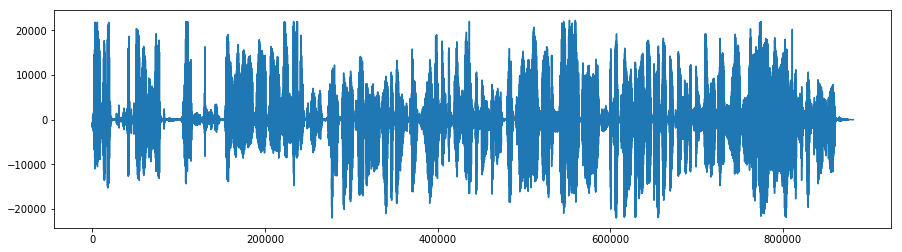

In [3]:
%matplotlib inline
import warnings
## scipy gives a waring when reading wav file
warnings.filterwarnings('ignore')

import scipy as sp
import scipy.io.wavfile
import scipy.signal
import numpy as np
from matplotlib import pyplot as plt

# sample_rate, wav_data = scipy.io.wavfile.read("audio-files/kombucha.wav")
sample_rate, wav_data = sp.io.wavfile.read("audio-files/radiolab_crispr.wav")
# sample_rate, wav_data = sp.io.wavfile.read("relief.wav")

## taking just one channel
mono_data = wav_data[:, 1]
audio_data = mono_data

print("rate:", sample_rate)
print("lenght (s):", len(audio_data) / sample_rate)

start_point = 130 * sample_rate
end_point = 20 * sample_rate + start_point # in seconds
if(len(audio_data) > end_point):
    print("trimming")
    audio_data = audio_data[start_point:end_point]

plt.figure(figsize=(15, 4))
plt.plot(audio_data)
plt.show()

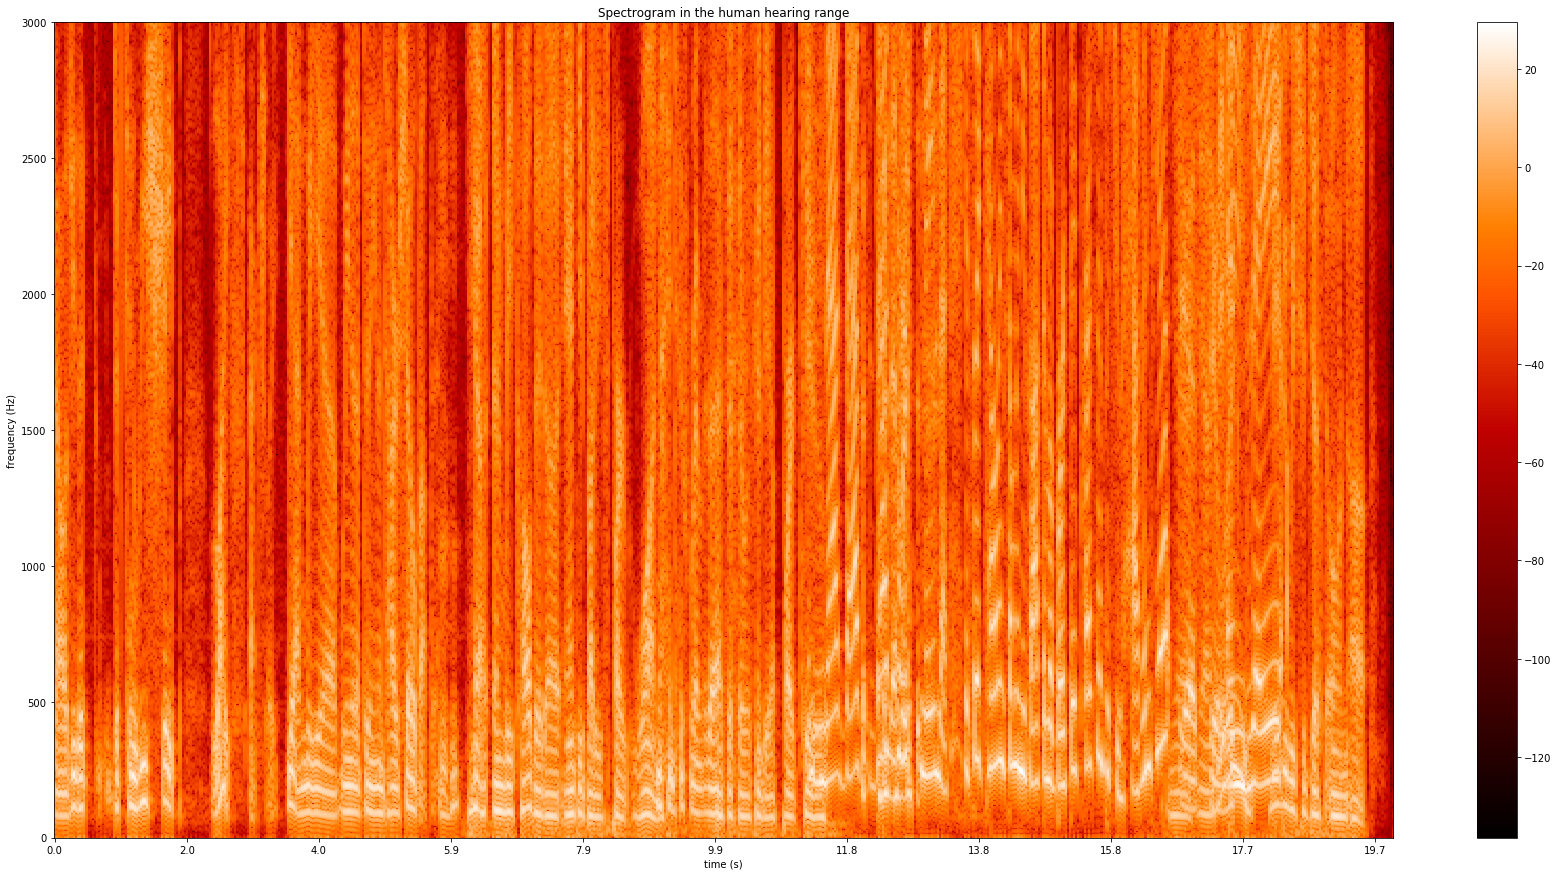

In [6]:
##
# Plotting the spectrogram in the human hearing range
##
from matplotlib.ticker import FormatStrFormatter

segment_length = int(sample_rate/16)
overlap = int(segment_length / 2)
freq_points, t_points, spectrogram = scipy.signal.spectrogram(audio_data, nperseg=segment_length, fs=sample_rate,
                                  noverlap=overlap, mode="psd", nfft=sample_rate)
## old overlap int(sample_rate/2)

## just the human hearing range
spectrogram = spectrogram[0:3000, :]

def todB(array):
    mean = np.mean(array)
    return 10 * np.log10(array / mean)


def plotSpectrogram(to_plot, yticks = np.array([]), cmap = plt.cm.gist_heat, subplot=111, _fig=False, fig_size=(30,15)):
    if (_fig == False):
        fig = plt.figure(figsize=fig_size)
    else:
        fig = _fig
    ax = fig.add_subplot(subplot)
    plt.imshow(to_plot, cmap=cmap)
    ax.set_aspect('auto')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    ## making pretty
    ax.set_ylim(ax.get_ylim()[::-1]) ## reversing axis
    plt.title("Spectrogram in the human hearing range")
    plt.xlabel("time (s)")
    plt.ylabel("frequency (Hz)")
    num_labels = 10
    xpoints = np.arange(to_plot.shape[1], step=int(to_plot.shape[1]/num_labels))
    plt.xticks(xpoints, np.round(t_points[xpoints], 1))
    if (yticks.size > 0):
        ypoints = np.arange(to_plot.shape[0], step=int(to_plot.shape[0]/num_labels))
        plt.yticks(ypoints, yticks[ypoints])
    plt.colorbar(orientation='vertical')
    return fig

f = plotSpectrogram(todB(spectrogram))

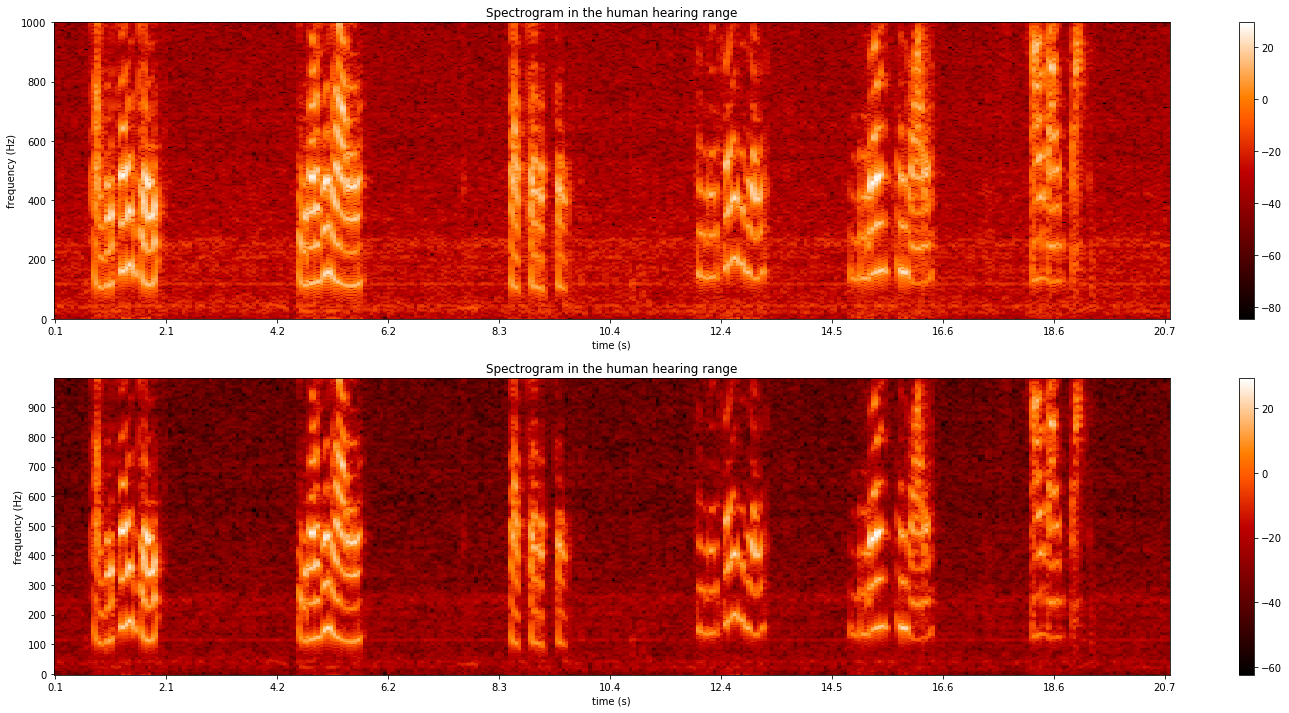

In [228]:
##
# Binning frequencies
##

band_width = 5
num_sections = int(spectrogram.shape[0] / band_width)
s = np.transpose(spectrogram)
s_re = np.reshape(s, (spectrogram.shape[1], num_sections, band_width))

## testing
if (all(s[0][0:band_width] == s_re[0][0]) != True):
    raise Exception("something went wrong reshping arrays!")

spectrogram_binned = np.transpose(np.sum(s_re, axis=2))
bands_id_array = np.arange(spectrogram_binned.shape[1])

f = plotSpectrogram(todB(spectrogram), subplot=211, fig_size=(25,12))
f = plotSpectrogram(todB(spectrogram_binned), bands_id_array * band_width, subplot=212, _fig=f)

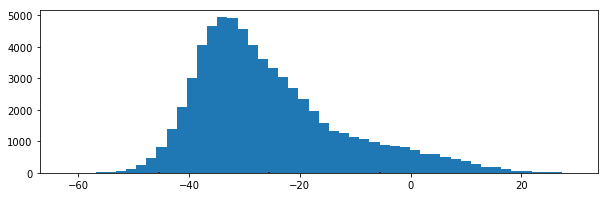

In [229]:
from matplotlib import pyplot as plt

bound_width = 1.5

flat_values = np.ndarray.flatten(spectrogram_binned)
flat_db_values = todB(flat_values)

## some basic stats calculations
mean = np.mean(flat_db_values)
sd = np.std(flat_db_values)
activation_bounds = (mean - bound_width * sd, mean + bound_width * sd)

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax.hist(flat_db_values, bins=50)
ax.vlines([mean, activation_bounds[0], activation_bounds[1]], 0, 40)
plt.show()

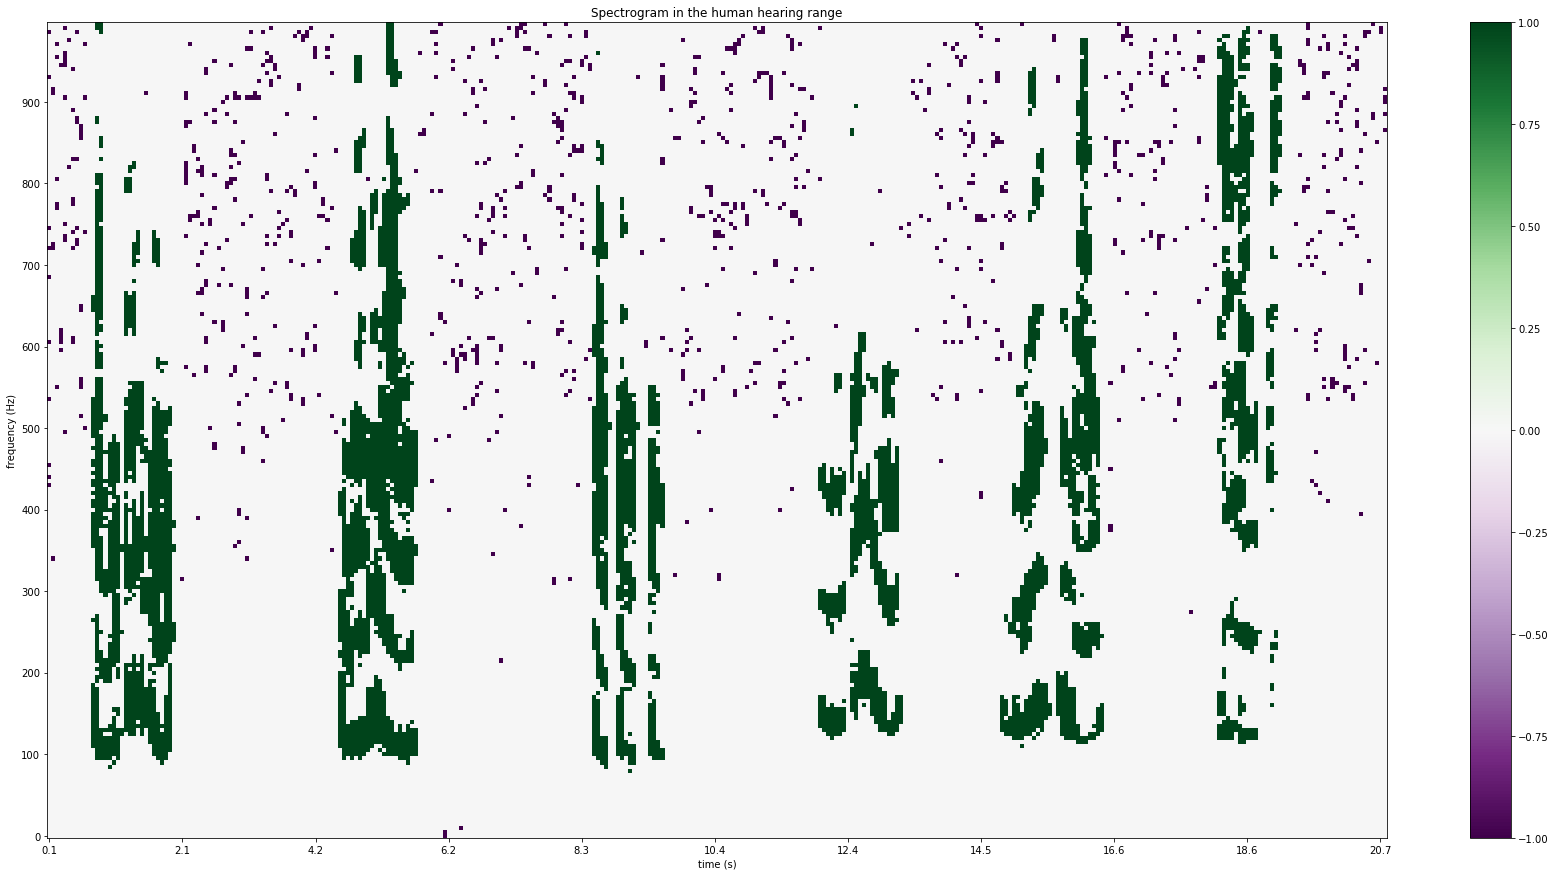

In [230]:
##
# so which spectrogram segments are outside the bounds?
##

sb_db = todB(spectrogram_binned)
spectrogram_outside_activation = np.zeros(spectrogram_binned.shape)
spectrogram_outside_activation[sb_db < activation_bounds[0]] = -1
spectrogram_outside_activation[sb_db > activation_bounds[1]] = 1
# print(spectrogram_outside_activation)
#spectrogram_outside_activation = (spectrogram_binned < activation_bounds[0]) | (spectrogram_binned > activation_bounds[1])

f = plotSpectrogram(spectrogram_outside_activation, bands_id_array * band_width, cmap=plt.cm.PRGn)

As can be seen on the spectrogram above (forced to -1,0,1), it is hard to tell apart the voices.
What to do? These artifacts could just be caused by being poisitioned further or closer to a microphone.

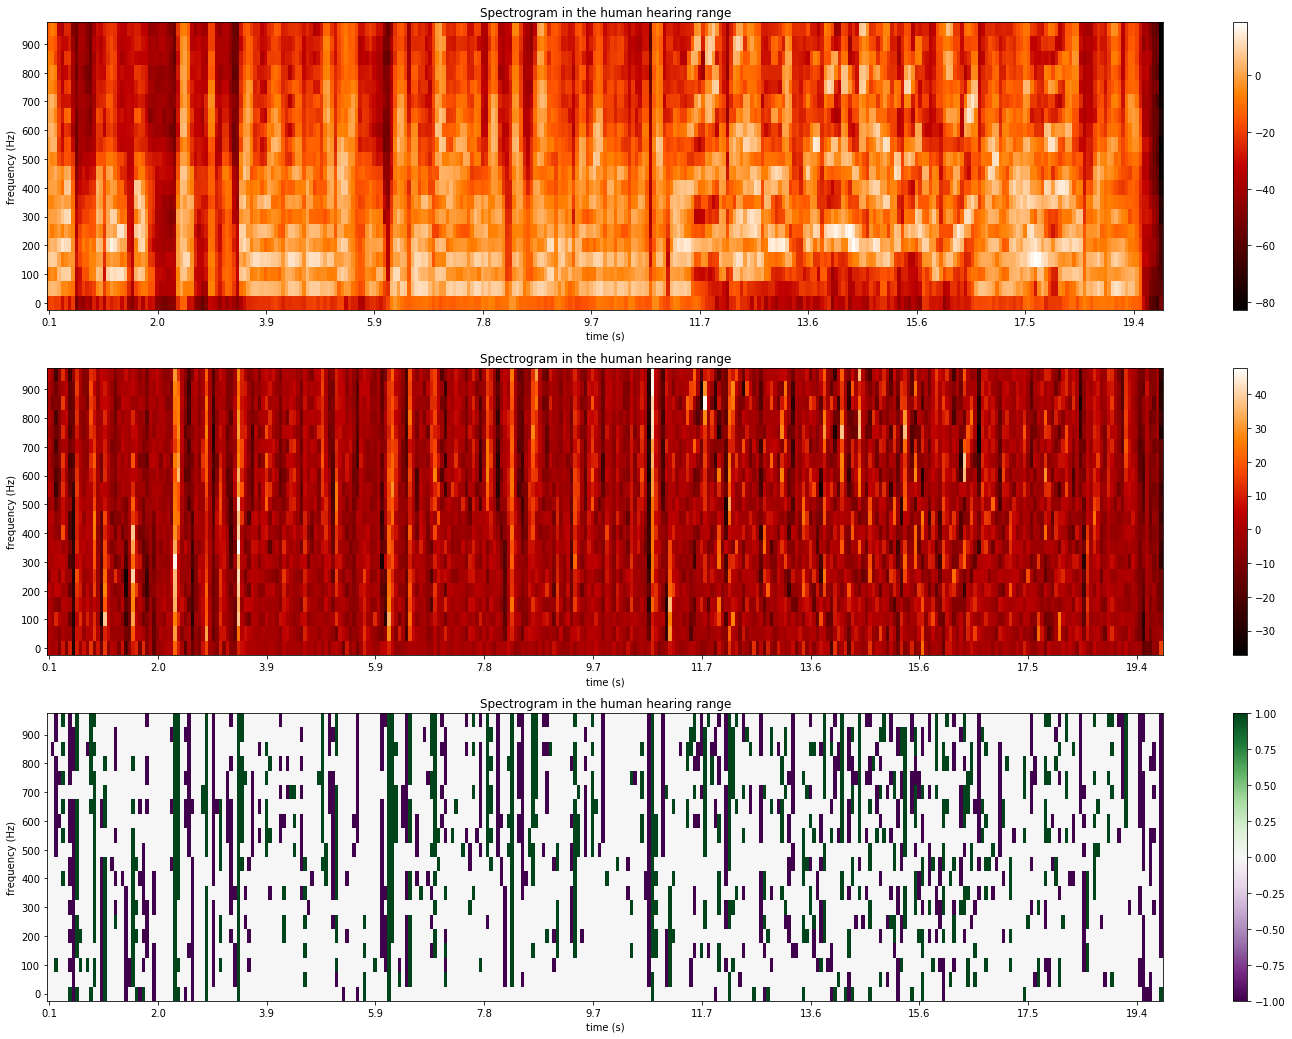

In [217]:
# What if we took the derivative of the spectrogram first?

# derivative of binned spectrogram in dB
dsbd = np.diff(todB(spectrogram_binned), axis=1)

# high/low activation of the first derivative
d_mean = np.mean(dsbd)
d_sd = np.std(dsbd)
d_hl = np.zeros(dsbd.shape)
sigma = 1 * d_sd
d_hl_b = (d_mean - sigma, d_mean + sigma)
d_hl[dsbd > d_hl_b[1]] = 1
d_hl[dsbd < d_hl_b[0]] = -1

def shift_graph(ar):
    ins = np.full(ar.shape[0], 0)
    ins = np.reshape(ins, (ar.shape[0], 1))
    return np.concatenate((ins, ar), axis=1)

f = plotSpectrogram(todB(spectrogram_binned), bands_id_array * band_width, subplot=311, fig_size = (25, 18))
f = plotSpectrogram(dsbd, bands_id_array * band_width, subplot=312, _fig=f)
f = plotSpectrogram(d_hl, bands_id_array * band_width, subplot=313, _fig=f, cmap=plt.cm.PRGn)


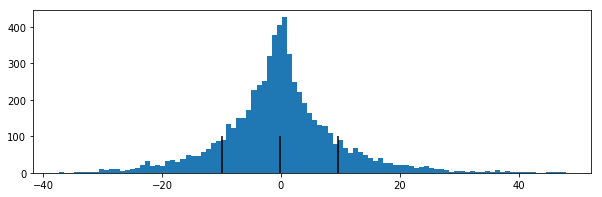

In [218]:
##
# What is the distribution of the first derivative?
##

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax.hist(np.ndarray.flatten(dsbd), bins=100)
ax.vlines([d_mean, d_hl_b[0], d_hl_b[1]], 0, 100)
plt.show()

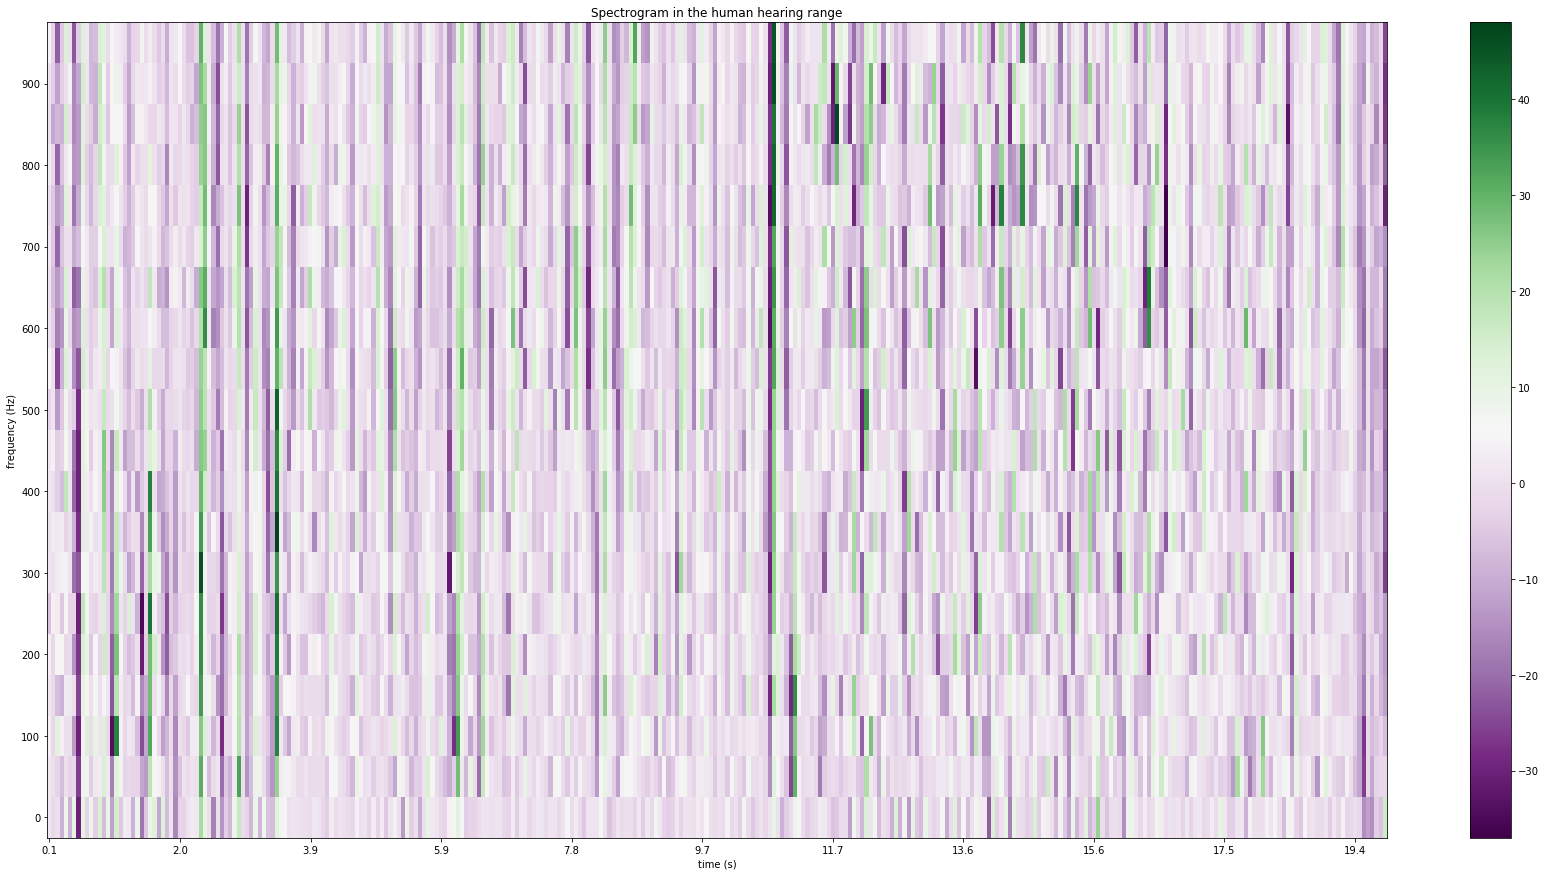

In [220]:
dsbd_r = np.rint(dsbd)
f = plotSpectrogram(dsbd_r, bands_id_array * band_width, cmap=plt.cm.PRGn)